In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

In [2]:
import renyi
import utils
reload(renyi)
from renyi import mink_sim_divergence, renyi_mixture_divergence, mink_mixture_divergence, rbf_kernel, generic_kernel

In [3]:
class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [4]:
def old_mixture_divergence(mu, X, nu, Y, kernel, alpha):   
    n, m = mu.shape[0], nu.shape[0]
    
    W = torch.cat((X, Y))
    
    # Compute similarity matrix
    K = kernel(W)
    
    v = (K[:n, :n] @ mu) / utils.min_clamp(K[:n, -m:] @ nu)
    v = mu.transpose(-2, -1) @ (v **(alpha-1))
    v = utils.clamp_log(v)
    
    u = (K[-m:, -m:] @ nu) / utils.min_clamp(K[-m:, :n] @ mu)
    u = nu.transpose(-2, -1) @ (u **(alpha-1))
    u = utils.clamp_log(u)
    
    return (u + v) / (alpha - 1)

def old_rbf_kernel(W, sigmas=[1.], p=2):
    pdist = torch.norm(W[..., None, :] - W[..., None, :, :], p=p, dim=-1)
    res = torch.zeros_like(pdist)
    for sigma in sigmas:
        res += torch.exp(- pdist / (2 * sigma**2))
    return res / len(sigmas)

In [237]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size = 1024

In [241]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

gaussian_kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2]))
old_kernel = lambda x: old_rbf_kernel(x, sigmas=[0.2])

In [242]:
alpha = 1

# emp_probs = 2*torch.ones(1, batch_size//2)/batch_size
emp_probs = torch.ones(1, batch_size).cuda()/batch_size

# for alpha=1:
# False, False, False: Negative, doesn't work
# False, False, True: Positive, works
# False, True, False: Negative, doesn't work
# False, True, True: Positive, works
# True, False, False: Negative, doesn't work
# True, False, True: Negative, doesn't work
# True, True, False: Negative, doesn't work
# True, True, True: Positive, works
D = lambda x, y: renyi_mixture_divergence(emp_probs, x, emp_probs, y, gaussian_kernel, alpha,
                                          use_avg=False, use_full=False, symmetric=True)

# for g in g_optimizer.param_groups:
#     g['lr'] = 1e-4

for _ in range(10000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

        x = x_real[:batch_size//2]
        x_prime = x_real[batch_size//2:]
        y = x_fake[:batch_size//2]
        y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
#         loss = 2*D(x, y) - D(y, y_prime)
        loss = D(x_real, x_fake)
#         loss = old_mixture_divergence(emp_probs.t(), x_real, emp_probs.t(), x_fake, old_kernel, alpha)

        if _ % 500 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 11.3091
500 - 0.6199
1000 - 0.2536
1500 - 0.1589
2000 - 0.2092
2500 - 0.1619
3000 - 0.1072
3500 - 0.1398
4000 - 0.0699
4500 - 0.1107
5000 - 0.1122
5500 - 0.0946
6000 - 0.0823
6500 - 0.0889
7000 - 0.1116
7500 - 0.1022
8000 - 0.1391
8500 - 0.0538
9000 - 0.1010
9500 - 0.0903


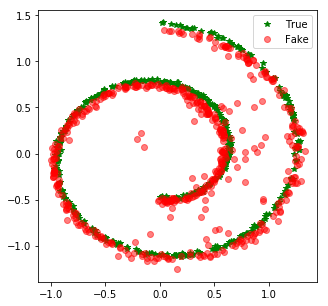

In [243]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', label='True')
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake')
plt.legend(loc='best');